In [1]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Palmer'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [3]:
def SVM(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }
    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val
    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        SVR(
            C=4,                # Complexidade do modelo
            epsilon=0.001,        # Epsilon para a perda insensível
            gamma=0.000465,     # Gamma do kernel (inverso do cacheSize em Weka)
            tol=0.0001,            # Tolerância para critério de parada
            cache_size=250007,    # Tamanho do cache
            verbose=False,        # Não exibir mensagens detalhadas
            max_iter=5000
    ))

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_cv, color='blue', label='Referência', marker='o', alpha=0.7)

    # Adicionar linha de calibração para os valores otimizados (y_pred_cv)
        plt.plot(y_train, slope_opt * y_train + offset_opt, color='blue', linestyle='--', label=f'Calibração (Slope={slope_opt:.2f}, Offset={offset_opt:.2f})')

    # Adicionar linha de calibração para os valores preditos (y_pred_train)
        plt.plot(y_train, slope_pred * y_train + offset_pred, color='red', linestyle='--', label=f'Predição (Slope={slope_pred:.2f}, Offset={offset_pred:.2f})')

    # Scatter plot para os valores preditos (y_pred_train)
        plt.scatter(y_train, y_pred_train, color='red', label='Predito', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

In [4]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

=== Training Metrics ===
R²: 0.1689
Correlation coefficient: 0.5594
RMSE: 2.6275
MAE: 1.9025
Relative absolute error: 76.6231
Root relative squared error: 91.1649
Slope: 1.8707
Offset: -5.5516
=== Cross-Validation Metrics ===
R²: -0.0704
Correlation coefficient: 0.1681
RMSE: 2.9819
MAE: 2.3458
Relative absolute error: 94.4728
Root relative squared error: 103.4622
Slope: 0.5957
Offset: 3.7715
=== Validation Metrics ===
R²: -0.5023
Correlation coefficient: 0.7832
RMSE: 3.1924
MAE: 2.7021
Relative absolute error: 135.3119
Root relative squared error: 122.5691
Slope: 2.4908
Offset: -8.7593


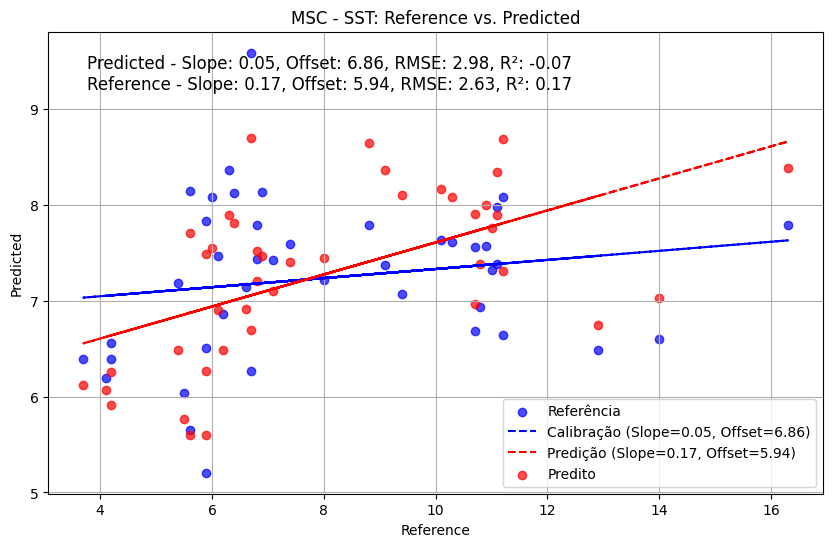

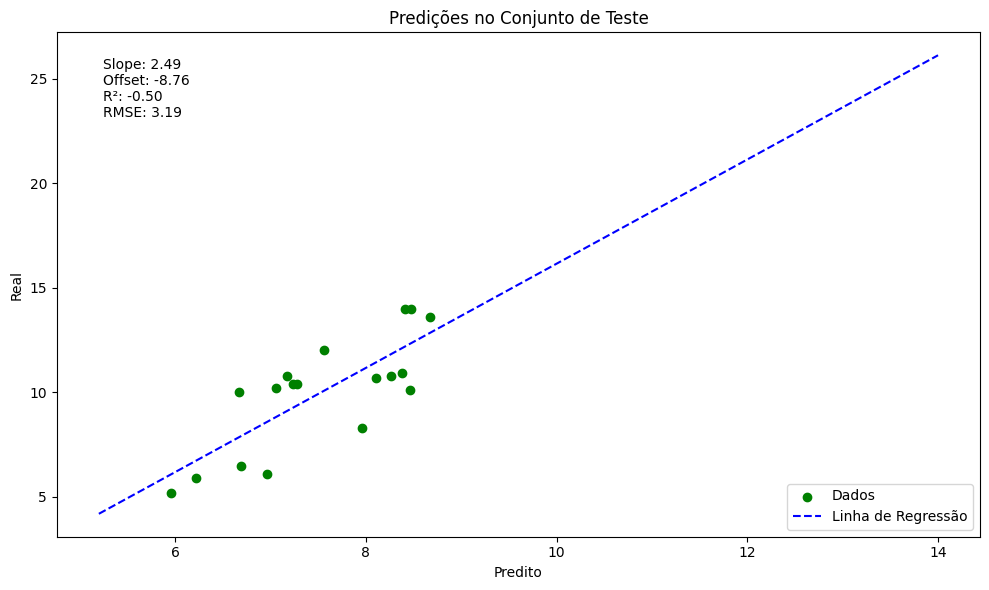

C:\Users\lenau\AppData\Local\Temp\ipykernel_1888\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [5]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 8:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 8:], df_msc_val['SST'].values, 'MSC', 'SST')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'SST')

=== Training Metrics ===
R²: -0.0212
Correlation coefficient: 0.6990
RMSE: 46.2041
MAE: 42.0756
Relative absolute error: 96.2353
Root relative squared error: 101.0523
Slope: 19.8863
Offset: -861.7247
=== Cross-Validation Metrics ===
R²: -0.1222
Correlation coefficient: -0.5788
RMSE: 48.4369
MAE: 44.5329
Relative absolute error: 101.8557
Root relative squared error: 105.9357
Slope: -12.8294
Offset: 653.0197
=== Validation Metrics ===
R²: -0.1095
Correlation coefficient: 0.5892
RMSE: 41.7404
MAE: 41.5332
Relative absolute error: 117.1379
Root relative squared error: 105.3319
Slope: 15.5069
Offset: -680.1132


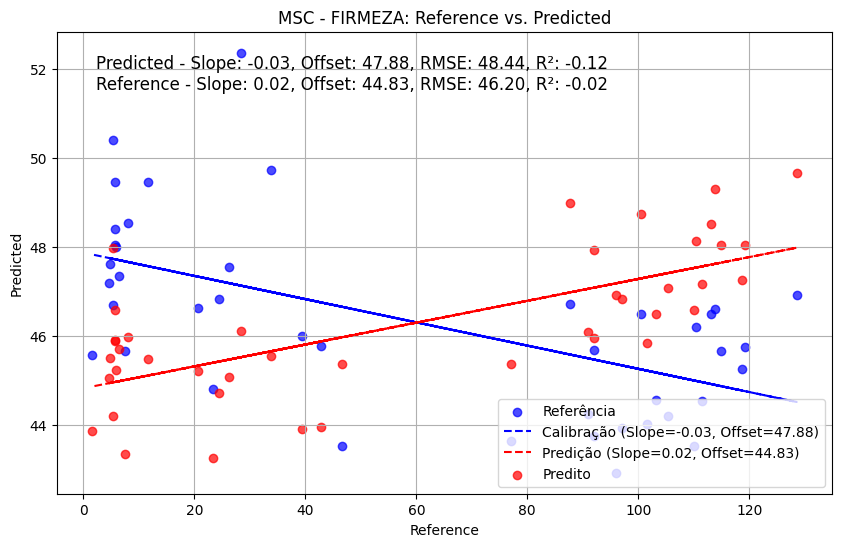

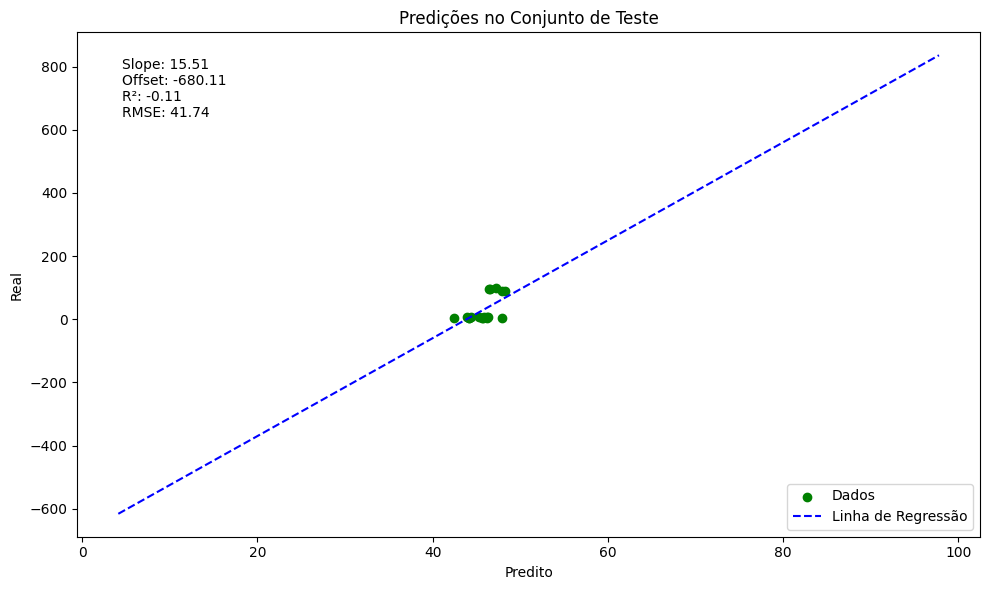

In [6]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 8:], df_msc_cal['FIRMEZA'].values, df_msc_val.iloc[:, 8:], df_msc_val['FIRMEZA'].values, 'MSC', 'FIRMEZA')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.1364
Correlation coefficient: 0.5024
RMSE: 6.1632
MAE: 4.6149
Relative absolute error: 90.1220
Root relative squared error: 92.9290
Slope: 3.0690
Offset: -60.8568
=== Cross-Validation Metrics ===
R²: -0.0060
Correlation coefficient: 0.0586
RMSE: 6.6521
MAE: 5.3110
Relative absolute error: 103.7154
Root relative squared error: 100.3015
Slope: 0.3776
Offset: 18.0610
=== Validation Metrics ===
R²: 0.1144
Correlation coefficient: 0.5093
RMSE: 4.2206
MAE: 3.3261
Relative absolute error: 94.9262
Root relative squared error: 94.1085
Slope: 2.2778
Offset: -36.7002


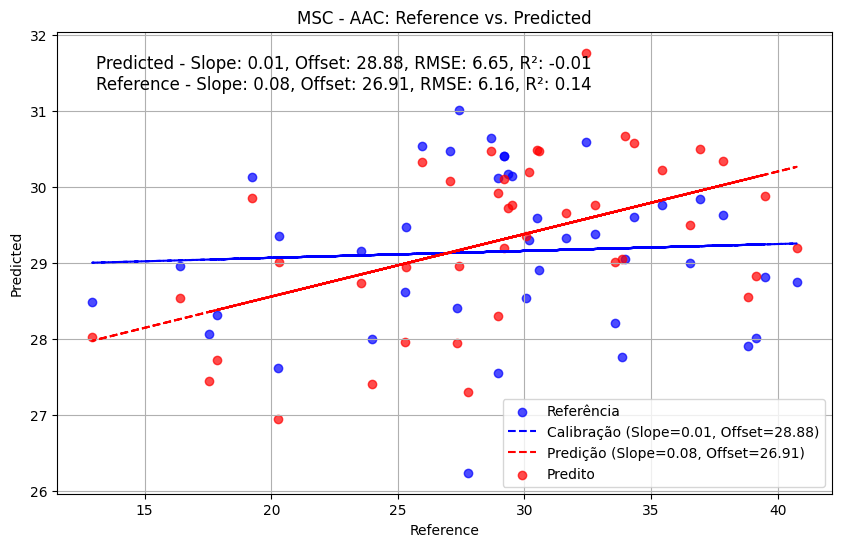

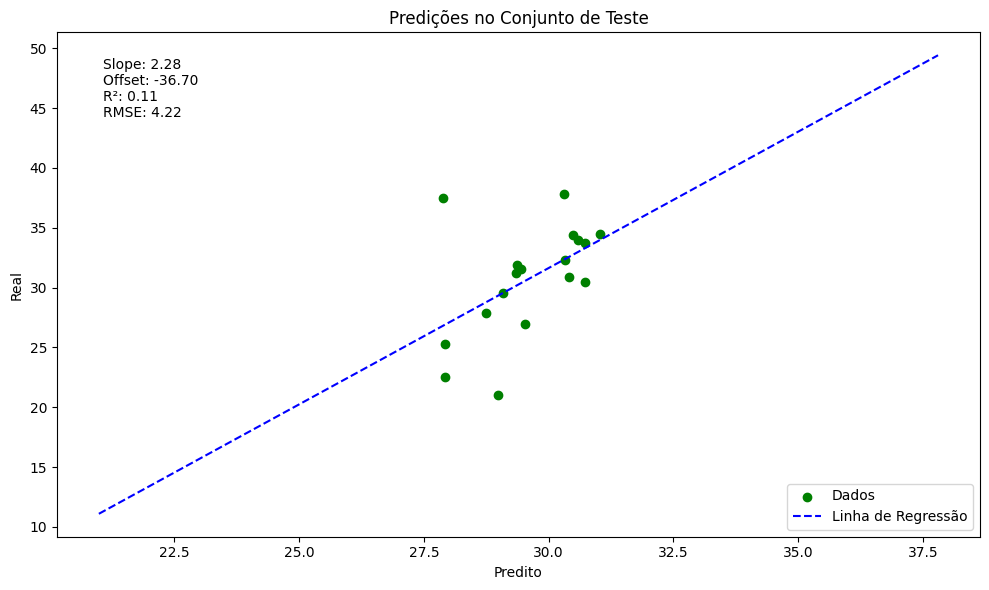

In [7]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 8:], df_msc_cal['AAC'].values, df_msc_val.iloc[:, 8:], df_msc_val['AAC'].values, 'MSC', 'AAC')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'AAC')

=== Training Metrics ===
R²: 0.6224
Correlation coefficient: 0.8010
RMSE: 0.0911
MAE: 0.0576
Relative absolute error: 48.0425
Root relative squared error: 61.4484
Slope: 1.1877
Offset: -0.0633
=== Cross-Validation Metrics ===
R²: -0.0913
Correlation coefficient: 0.2815
RMSE: 0.1548
MAE: 0.1270
Relative absolute error: 105.9653
Root relative squared error: 104.4656
Slope: 0.4074
Offset: 0.2339
=== Validation Metrics ===
R²: 0.0202
Correlation coefficient: 0.2604
RMSE: 0.1442
MAE: 0.1200
Relative absolute error: 95.8932
Root relative squared error: 98.9847
Slope: 0.5531
Offset: 0.1324


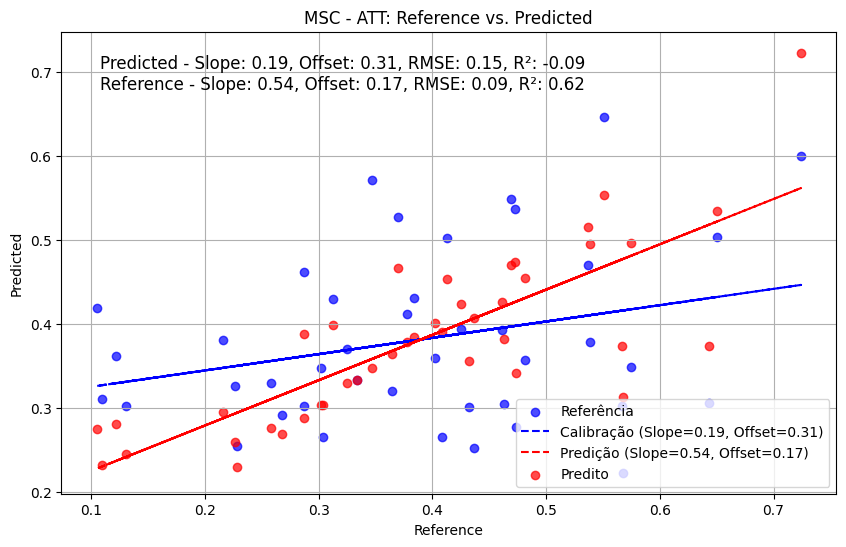

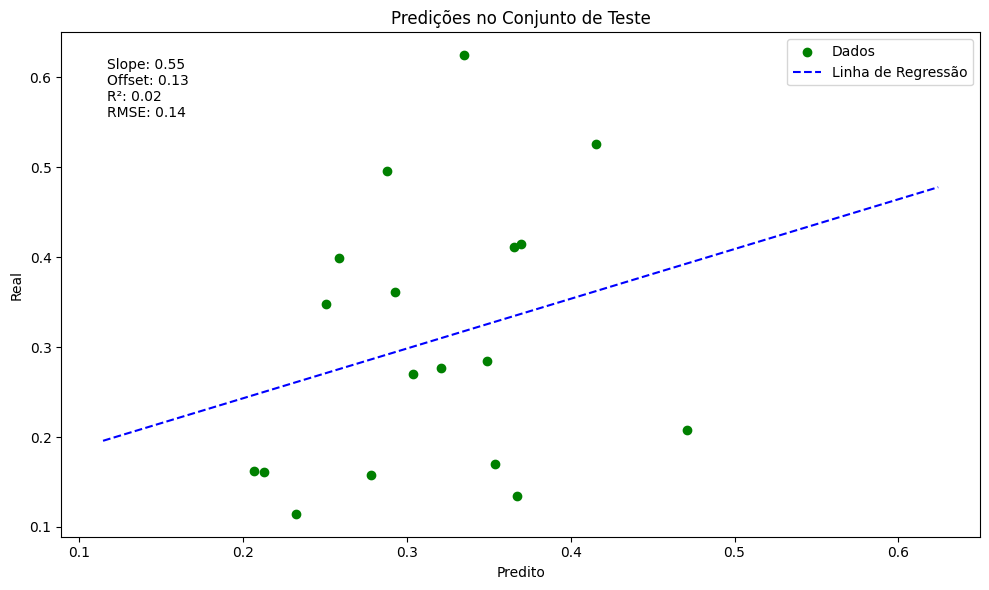

In [8]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 8:], df_msc_cal['ATT'].values, df_msc_val.iloc[:, 8:], df_msc_val['ATT'].values, 'MSC', 'ATT')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'ATT')

=== Training Metrics ===
R²: 0.9696
Correlation coefficient: 0.9870
RMSE: 0.0046
MAE: 0.0025
Relative absolute error: 11.6943
Root relative squared error: 17.4234
Slope: 1.0580
Offset: -0.0087
=== Cross-Validation Metrics ===
R²: -0.2795
Correlation coefficient: 0.2901
RMSE: 0.0295
MAE: 0.0237
Relative absolute error: 111.6947
Root relative squared error: 113.1136
Slope: 0.3249
Offset: 0.0878
=== Validation Metrics ===
R²: -0.0648
Correlation coefficient: 0.5380
RMSE: 0.0176
MAE: 0.0128
Relative absolute error: 91.7404
Root relative squared error: 103.1889
Slope: 0.4848
Offset: 0.0709


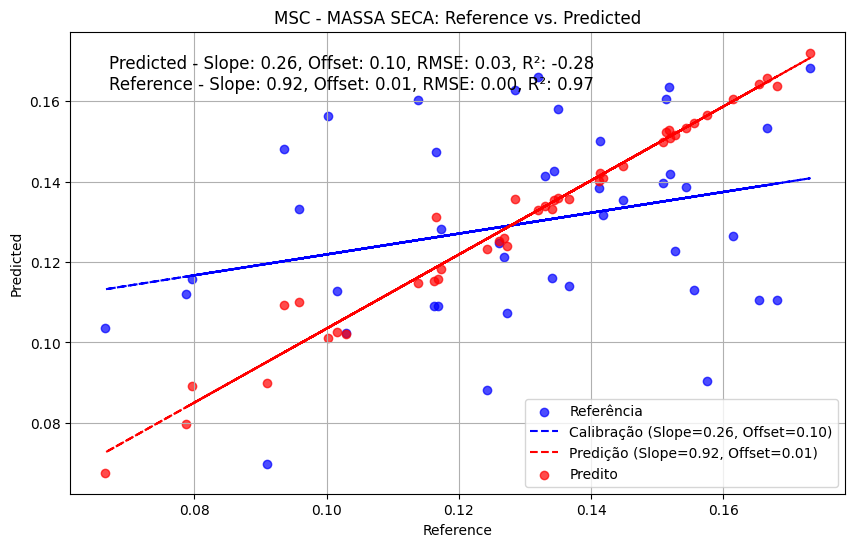

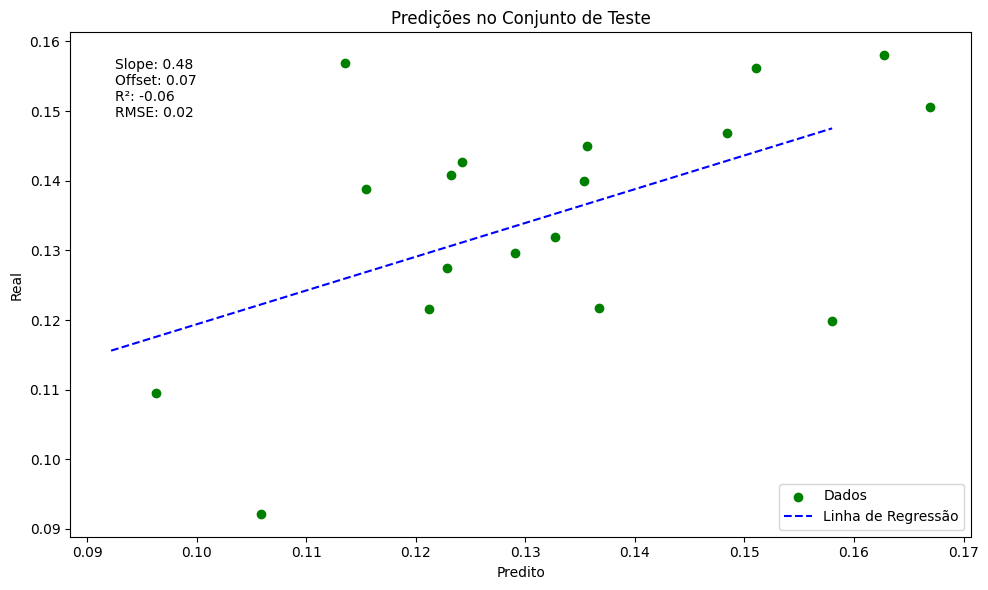

In [9]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 8:], df_msc_cal['MASSA SECA'].values, df_msc_val.iloc[:, 8:], df_msc_val['MASSA SECA'].values, 'MSC', 'MASSA SECA')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'MASSA SECA')

In [10]:
infos_msc.to_excel('plot_infos_SVM_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.168897,0.559391,2.627456,1.902547,76.623143,91.164855,1.870696,-5.551586
1,SST,Cross-Validation,-0.070443,0.168119,2.981878,2.345753,94.472789,103.462215,0.595713,3.771534
2,SST,Validation,-0.502320,0.783191,3.192416,2.702062,135.311898,122.569146,2.490843,-8.759262
3,FIRMEZA,Training,-0.021157,0.698962,46.204110,42.075603,96.235280,101.052324,19.886262,-861.724729
4,FIRMEZA,Cross-Validation,-0.122237,-0.578804,48.436933,44.532940,101.855699,105.935698,-12.829422,653.019702
5,FIRMEZA,Validation,-0.109480,0.589241,41.740393,41.533170,117.137932,105.331871,15.506911,-680.113226
6,AAC,Training,0.136421,0.502365,6.163179,4.614937,90.121963,92.928959,3.068953,-60.856807
7,AAC,Cross-Validation,-0.006039,0.058572,6.652138,5.311026,103.715414,100.301517,0.377581,18.060992
8,AAC,Validation,0.114360,0.509273,4.220603,3.326136,94.926204,94.108455,2.277825,-36.700229
9,ATT,Training,0.622410,0.800966,0.091075,0.057579,48.042465,61.448356,1.187744,-0.063263


=== Training Metrics ===
R²: 0.2157
Correlation coefficient: 0.5931
RMSE: 2.5333
MAE: 1.8378
Relative absolute error: 74.9414
Root relative squared error: 88.5626
Slope: 1.9086
Offset: -6.0941
=== Cross-Validation Metrics ===
R²: 0.0035
Correlation coefficient: 0.2682
RMSE: 2.8554
MAE: 2.2673
Relative absolute error: 92.4542
Root relative squared error: 99.8239
Slope: 0.8813
Offset: 1.6185
=== Validation Metrics ===
R²: -0.2998
Correlation coefficient: 0.7699
RMSE: 3.1182
MAE: 2.7109
Relative absolute error: 125.6569
Root relative squared error: 114.0101
Slope: 2.5123
Offset: -9.2900


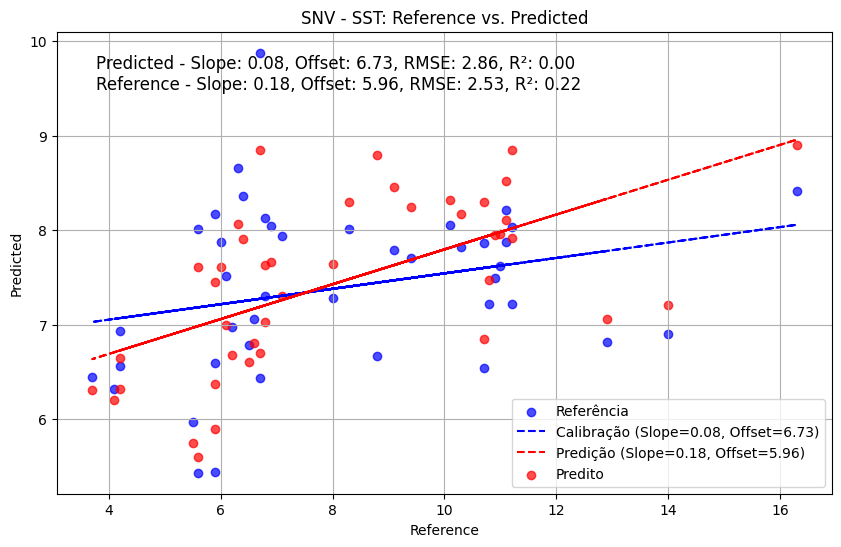

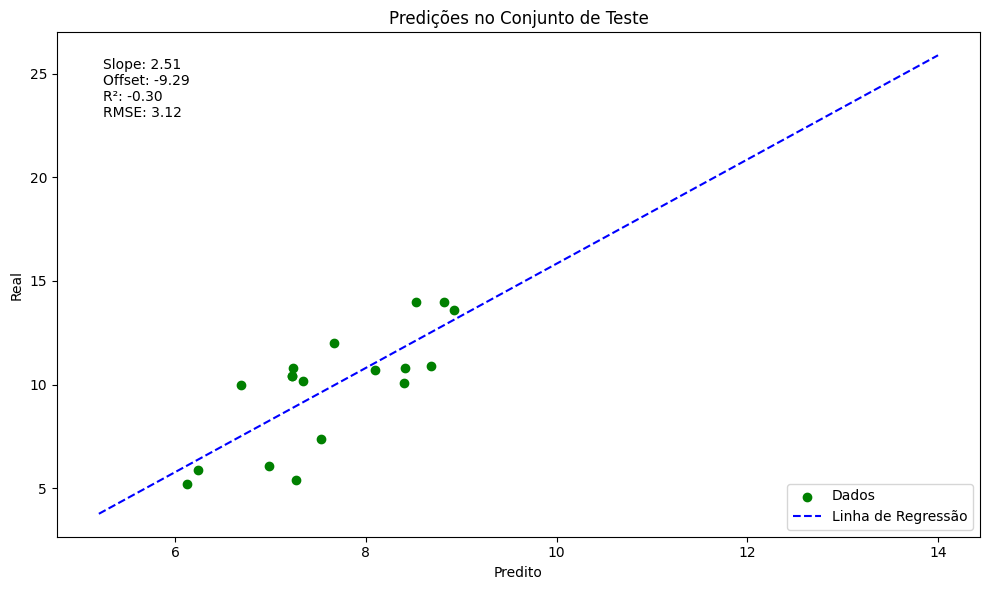

C:\Users\lenau\AppData\Local\Temp\ipykernel_1888\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [11]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 8:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 8:], df_snv_val['SST'].values, 'SNV', 'SST')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'SST')

=== Training Metrics ===
R²: -0.0245
Correlation coefficient: 0.6782
RMSE: 46.2621
MAE: 41.9269
Relative absolute error: 95.9472
Root relative squared error: 101.2200
Slope: 17.5674
Offset: -744.6426
=== Cross-Validation Metrics ===
R²: -0.1072
Correlation coefficient: -0.4696
RMSE: 48.0913
MAE: 43.9706
Relative absolute error: 100.6239
Root relative squared error: 105.2222
Slope: -13.5827
Offset: 681.2277
=== Validation Metrics ===
R²: -0.1114
Correlation coefficient: 0.3937
RMSE: 41.8673
MAE: 41.5868
Relative absolute error: 117.0377
Root relative squared error: 105.4215
Slope: 10.4701
Offset: -443.0078


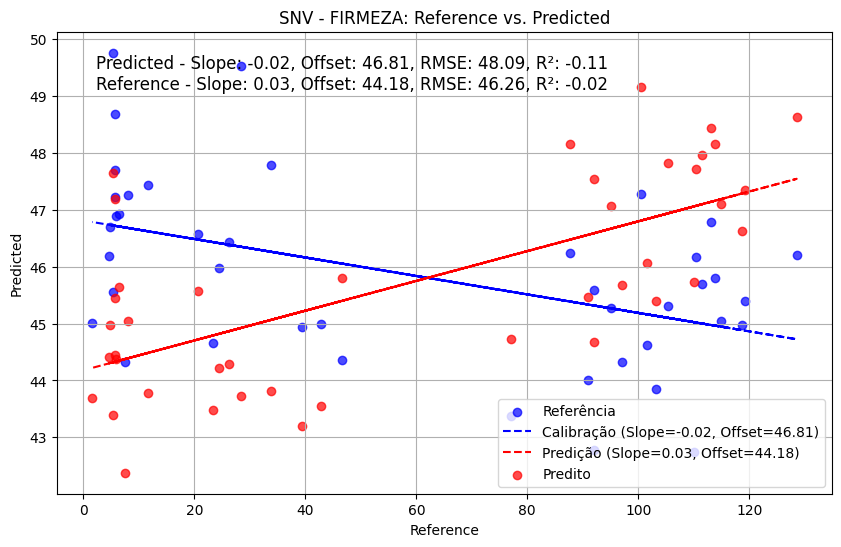

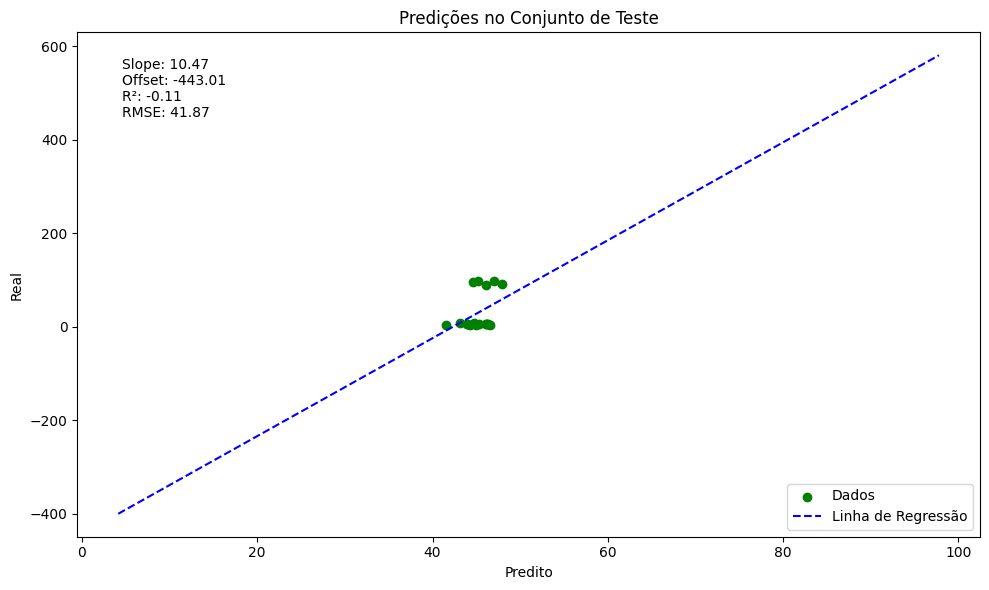

In [12]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 8:], df_snv_cal['FIRMEZA'].values, df_snv_val.iloc[:, 8:], df_snv_val['FIRMEZA'].values, 'SNV', 'FIRMEZA')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.1355
Correlation coefficient: 0.4984
RMSE: 6.1495
MAE: 4.5509
Relative absolute error: 89.4221
Root relative squared error: 92.9781
Slope: 3.0309
Offset: -59.9729
=== Cross-Validation Metrics ===
R²: 0.0244
Correlation coefficient: 0.1631
RMSE: 6.5329
MAE: 5.0742
Relative absolute error: 99.7051
Root relative squared error: 98.7747
Slope: 0.9278
Offset: 1.8275
=== Validation Metrics ===
R²: 0.1337
Correlation coefficient: 0.5209
RMSE: 4.3047
MAE: 3.4788
Relative absolute error: 92.7251
Root relative squared error: 93.0778
Slope: 2.4908
Offset: -43.1423


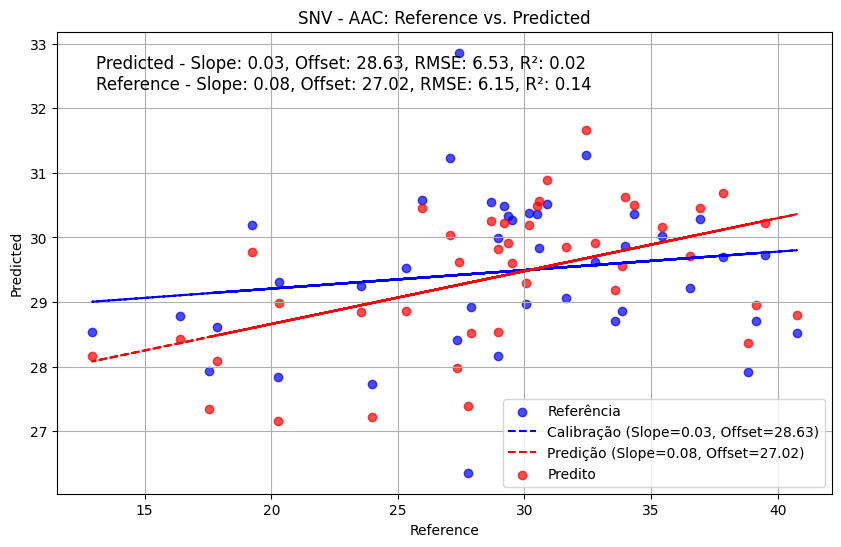

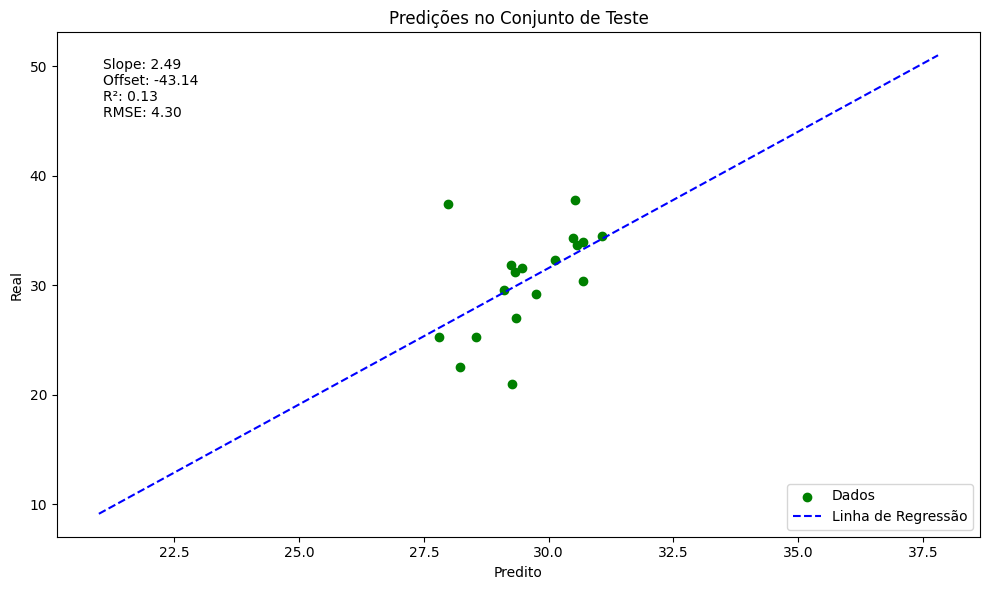

In [13]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 8:], df_snv_cal['AAC'].values, df_snv_val.iloc[:, 8:], df_snv_val['AAC'].values, 'SNV', 'AAC')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'AAC')

=== Training Metrics ===
R²: 0.5161
Correlation coefficient: 0.7235
RMSE: 0.0973
MAE: 0.0573
Relative absolute error: 49.7882
Root relative squared error: 69.5655
Slope: 1.1336
Offset: -0.0495
=== Cross-Validation Metrics ===
R²: -0.4583
Correlation coefficient: 0.0957
RMSE: 0.1689
MAE: 0.1337
Relative absolute error: 116.2055
Root relative squared error: 120.7612
Slope: 0.1228
Offset: 0.3377
=== Validation Metrics ===
R²: 0.0935
Correlation coefficient: 0.4306
RMSE: 0.1608
MAE: 0.1308
Relative absolute error: 95.0446
Root relative squared error: 95.2128
Slope: 0.8780
Offset: -0.0053


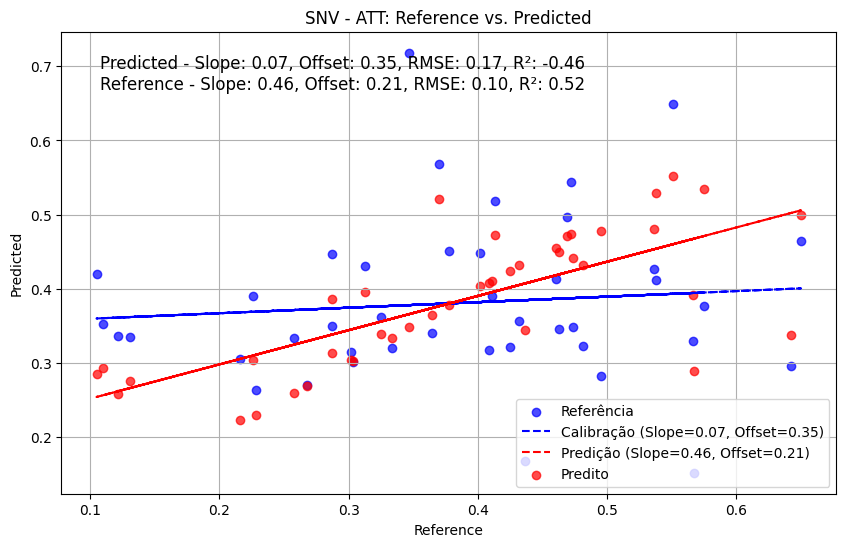

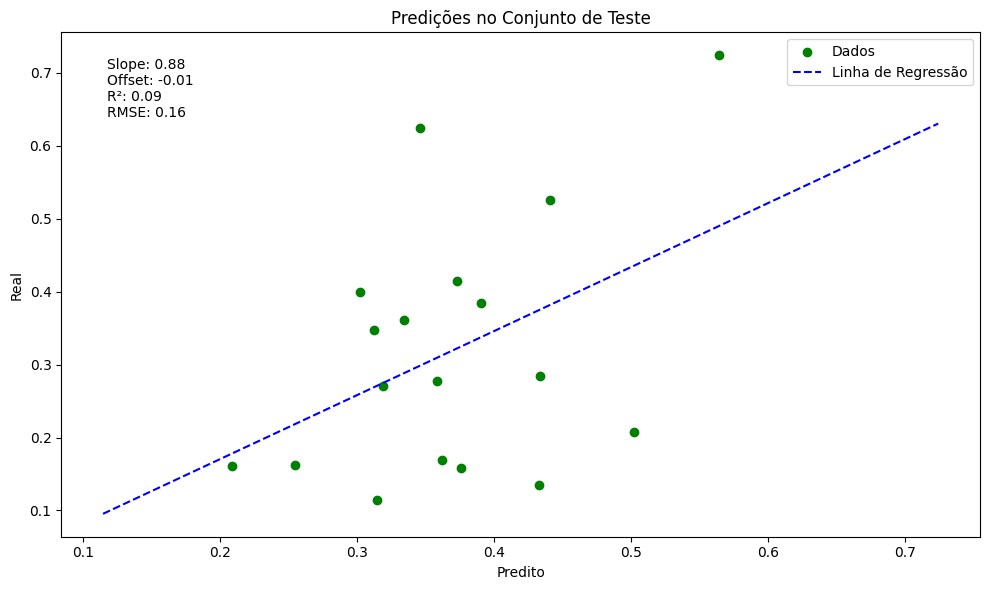

In [14]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 8:], df_snv_cal['ATT'].values, df_snv_val.iloc[:, 8:], df_snv_val['ATT'].values, 'SNV', 'ATT')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'ATT')

=== Training Metrics ===
R²: 0.9643
Correlation coefficient: 0.9851
RMSE: 0.0049
MAE: 0.0026
Relative absolute error: 12.5685
Root relative squared error: 18.8959
Slope: 1.0674
Offset: -0.0101
=== Cross-Validation Metrics ===
R²: -0.5587
Correlation coefficient: 0.2183
RMSE: 0.0323
MAE: 0.0249
Relative absolute error: 119.7000
Root relative squared error: 124.8472
Slope: 0.2190
Offset: 0.1024
=== Validation Metrics ===
R²: 0.1615
Correlation coefficient: 0.5838
RMSE: 0.0167
MAE: 0.0115
Relative absolute error: 75.7761
Root relative squared error: 91.5671
Slope: 0.5874
Offset: 0.0558


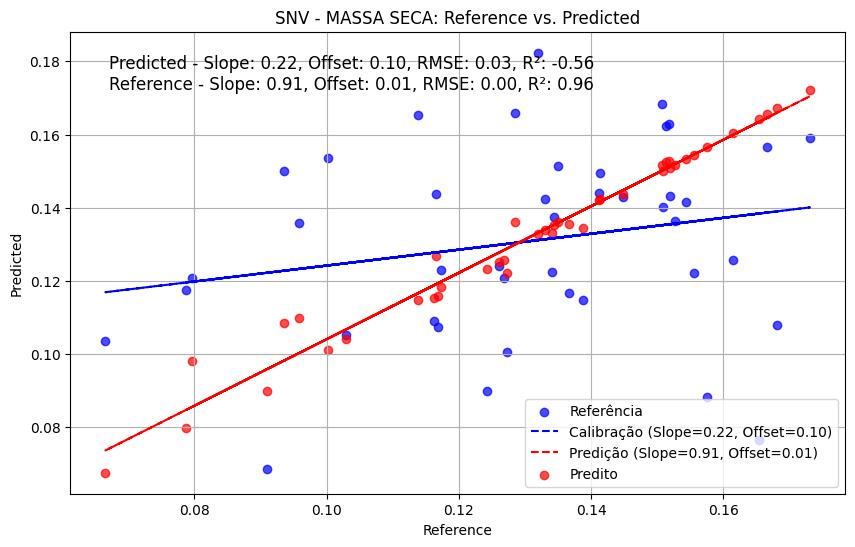

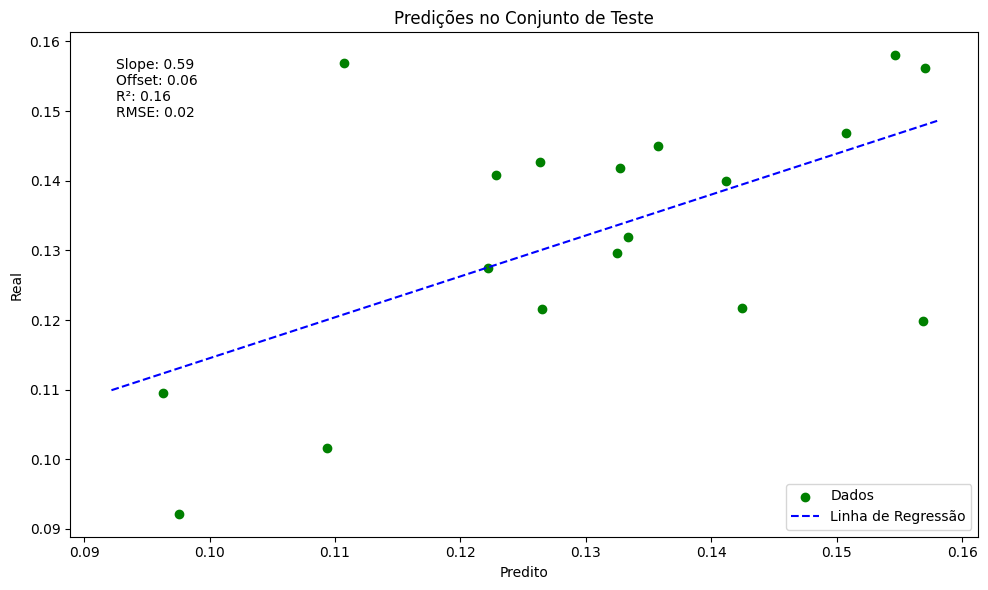

In [15]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 8:], df_snv_cal['MASSA SECA'].values, df_snv_val.iloc[:, 8:], df_snv_val['MASSA SECA'].values, 'SNV', 'MASSA SECA')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'MASSA SECA')

In [16]:
infos_snv.to_excel('plot_infos_SVM_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.215666,0.593071,2.533297,1.837849,74.941431,88.562628,1.908621,-6.094104
1,SST,Cross-Validation,0.003519,0.268169,2.855422,2.267329,92.454180,99.823917,0.881289,1.618477
2,SST,Validation,-0.299831,0.769899,3.118188,2.710932,125.656921,114.010123,2.512339,-9.289984
3,FIRMEZA,Training,-0.024548,0.678207,46.262091,41.926912,95.947195,101.219952,17.567362,-744.642585
4,FIRMEZA,Cross-Validation,-0.107170,-0.469628,48.091283,43.970555,100.623950,105.222164,-13.582704,681.227704
5,FIRMEZA,Validation,-0.111370,0.393749,41.867345,41.586839,117.037658,105.421539,10.470133,-443.007765
6,AAC,Training,0.135508,0.498354,6.149544,4.550922,89.422134,92.978080,3.030934,-59.972935
7,AAC,Cross-Validation,0.024355,0.163050,6.532934,5.074246,99.705057,98.774733,0.927777,1.827520
8,AAC,Validation,0.133653,0.520931,4.304713,3.478835,92.725103,93.077778,2.490761,-43.142289
9,ATT,Training,0.516064,0.723507,0.097271,0.057266,49.788172,69.565540,1.133577,-0.049546


=== Training Metrics ===
R²: 0.2234
Correlation coefficient: 0.5751
RMSE: 2.5398
MAE: 1.8558
Relative absolute error: 74.7405
Root relative squared error: 88.1247
Slope: 1.5479
Offset: -3.2846
=== Cross-Validation Metrics ===
R²: 0.0311
Correlation coefficient: 0.3199
RMSE: 2.8370
MAE: 2.2591
Relative absolute error: 90.9821
Root relative squared error: 98.4350
Slope: 0.8493
Offset: 1.8569
=== Validation Metrics ===
R²: -0.4008
Correlation coefficient: 0.6927
RMSE: 3.0827
MAE: 2.6984
Relative absolute error: 135.1273
Root relative squared error: 118.3557
Slope: 2.4344
Offset: -8.9782


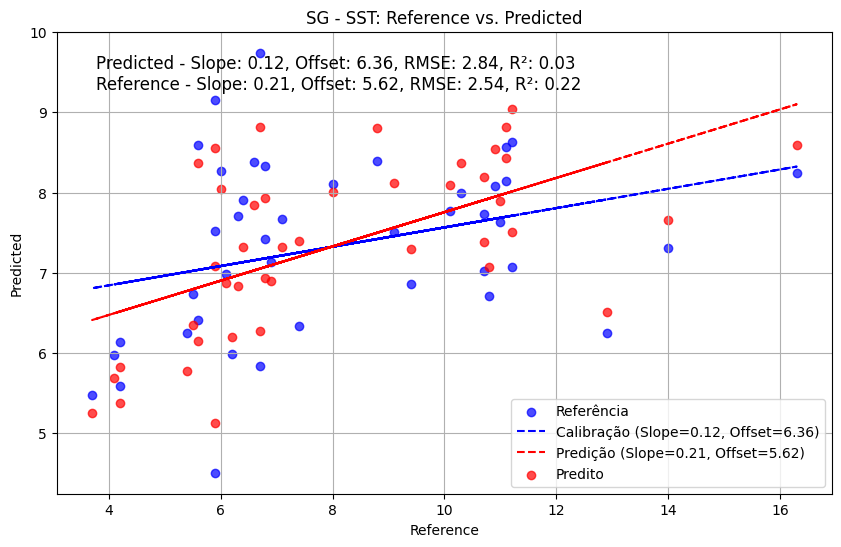

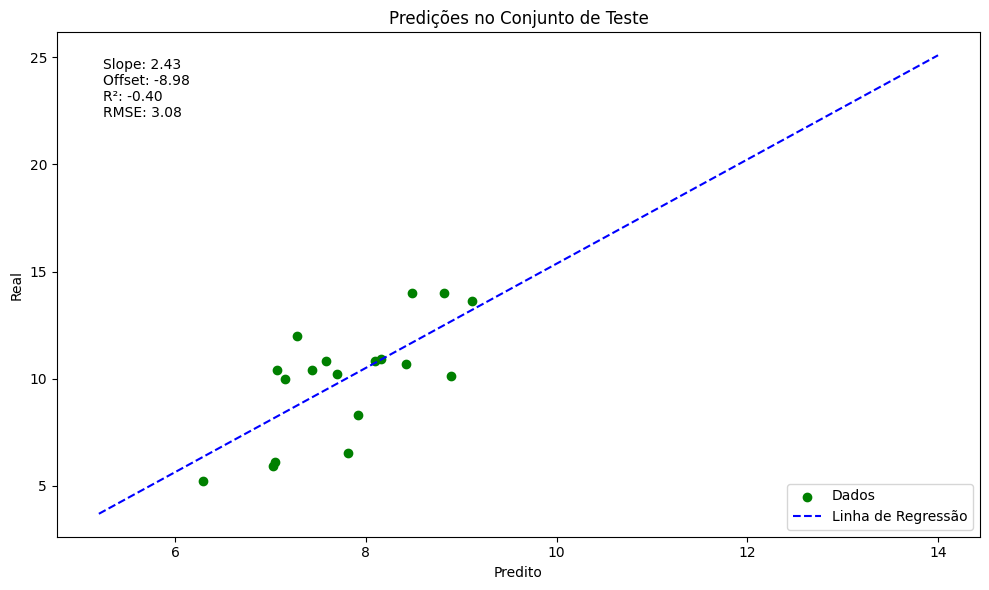

C:\Users\lenau\AppData\Local\Temp\ipykernel_1888\2636434218.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [17]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 8:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 8:], df_sg_val['SST'].values, 'SG', 'SST')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'SST')

=== Training Metrics ===
R²: 0.1013
Correlation coefficient: 0.6131
RMSE: 43.3446
MAE: 39.3234
Relative absolute error: 89.9405
Root relative squared error: 94.7983
Slope: 4.4995
Offset: -159.2518
=== Cross-Validation Metrics ===
R²: 0.0227
Correlation coefficient: 0.3707
RMSE: 45.2010
MAE: 41.2988
Relative absolute error: 94.4587
Root relative squared error: 98.8585
Slope: 3.2346
Offset: -97.4461
=== Validation Metrics ===
R²: -0.1040
Correlation coefficient: 0.2902
RMSE: 41.6378
MAE: 41.2465
Relative absolute error: 116.3294
Root relative squared error: 105.0730
Slope: 2.4307
Offset: -81.8041


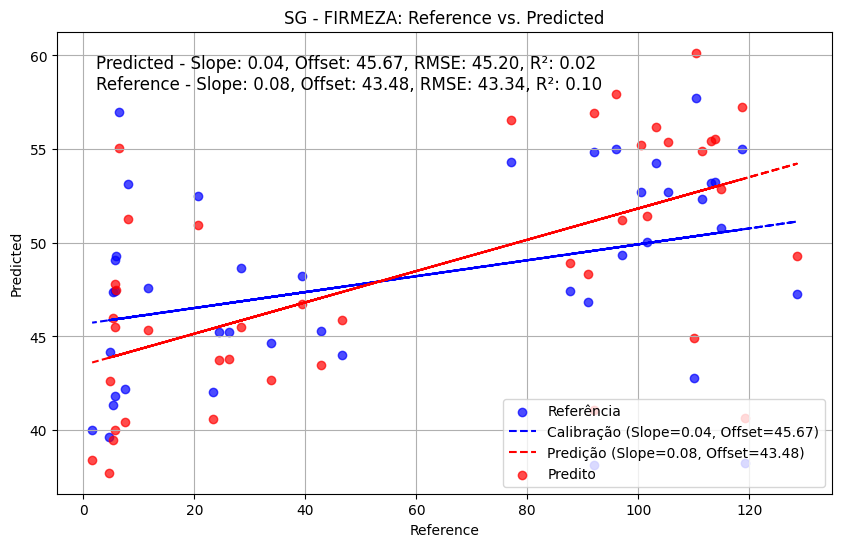

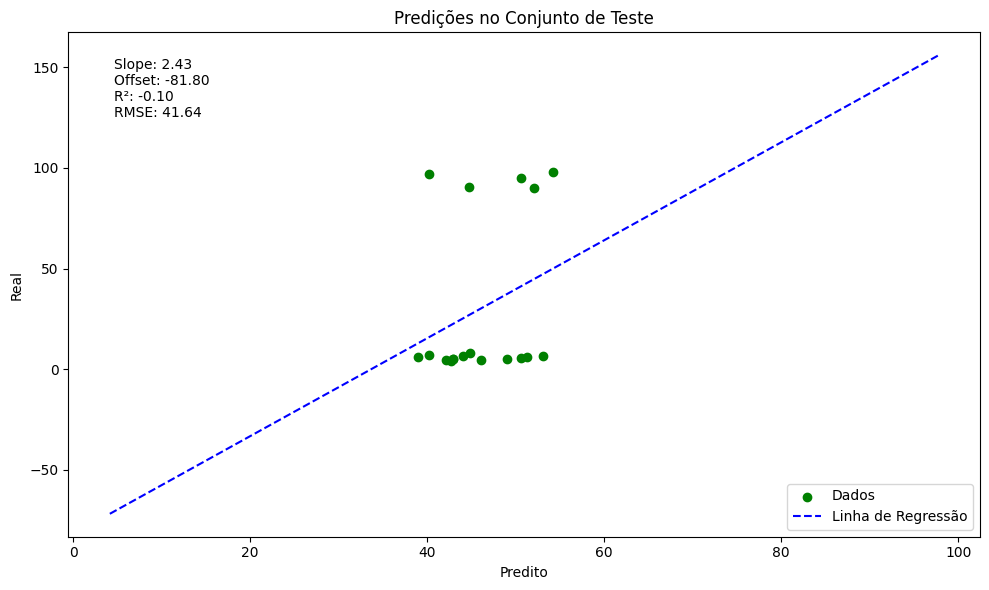

In [18]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 8:], df_sg_cal['FIRMEZA'].values, df_sg_val.iloc[:, 8:], df_sg_val['FIRMEZA'].values, 'SG', 'FIRMEZA')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'FIRMEZA')

=== Training Metrics ===
R²: 0.1900
Correlation coefficient: 0.5468
RMSE: 5.9689
MAE: 4.4803
Relative absolute error: 87.4931
Root relative squared error: 89.9995
Slope: 2.5093
Offset: -44.3411
=== Cross-Validation Metrics ===
R²: 0.1213
Correlation coefficient: 0.3989
RMSE: 6.2169
MAE: 4.8016
Relative absolute error: 93.7681
Root relative squared error: 93.7387
Slope: 1.9303
Offset: -27.4191
=== Validation Metrics ===
R²: 0.1667
Correlation coefficient: 0.5698
RMSE: 4.0941
MAE: 3.2562
Relative absolute error: 92.9299
Root relative squared error: 91.2875
Slope: 2.3820
Offset: -40.1156


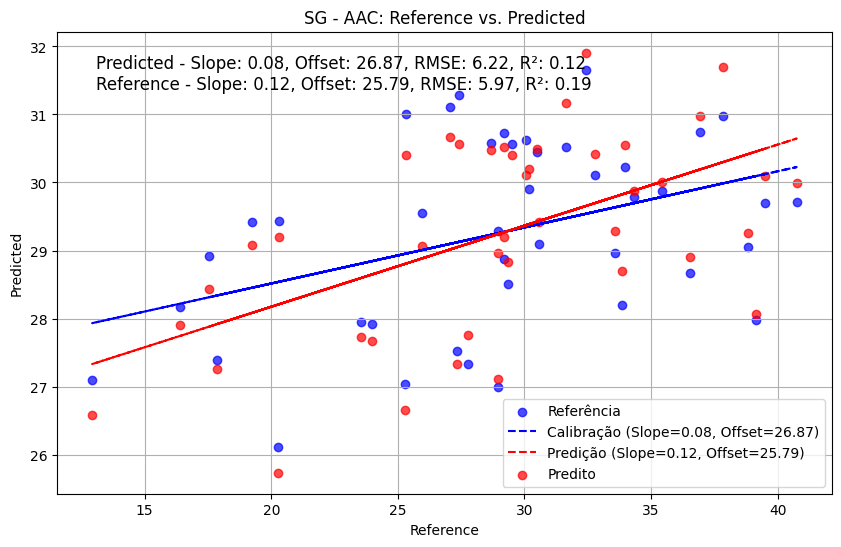

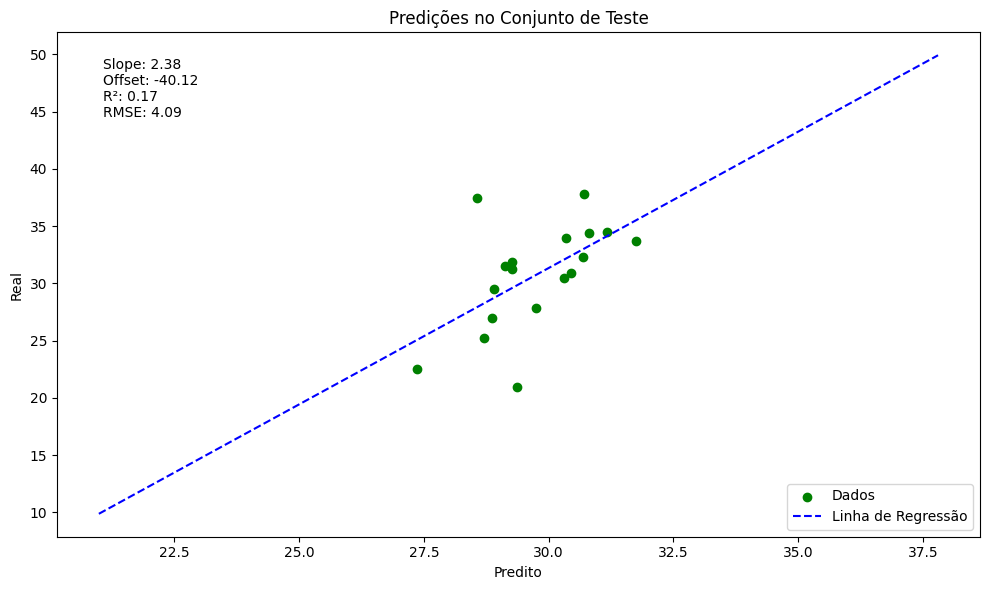

In [19]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 8:], df_sg_cal['AAC'].values, df_sg_val.iloc[:, 8:], df_sg_val['AAC'].values, 'SG', 'AAC')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'AAC')

=== Training Metrics ===
R²: 0.6303
Correlation coefficient: 0.8024
RMSE: 0.0901
MAE: 0.0561
Relative absolute error: 46.7786
Root relative squared error: 60.8033
Slope: 1.1601
Offset: -0.0563
=== Cross-Validation Metrics ===
R²: 0.0295
Correlation coefficient: 0.3772
RMSE: 0.1460
MAE: 0.1197
Relative absolute error: 99.9066
Root relative squared error: 98.5135
Slope: 0.5312
Offset: 0.1860
=== Validation Metrics ===
R²: 0.2039
Correlation coefficient: 0.5172
RMSE: 0.1300
MAE: 0.1100
Relative absolute error: 87.9332
Root relative squared error: 89.2243
Slope: 0.8737
Offset: 0.0081


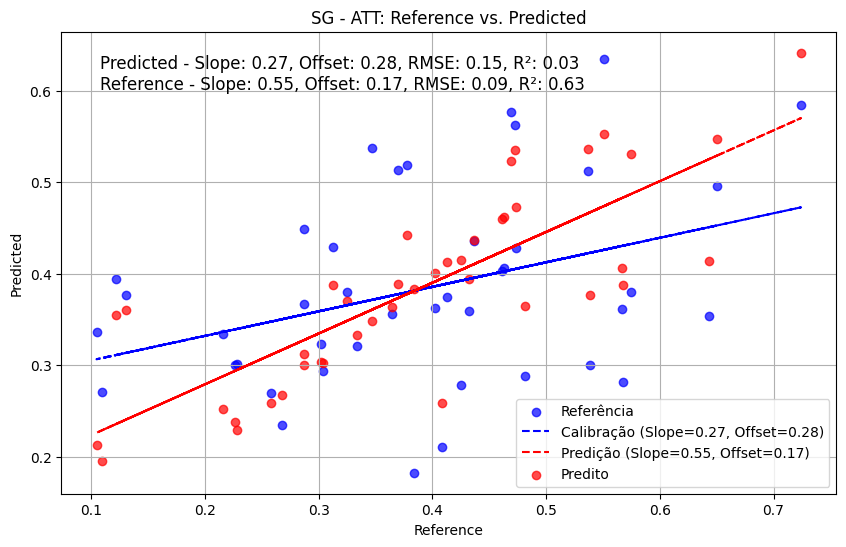

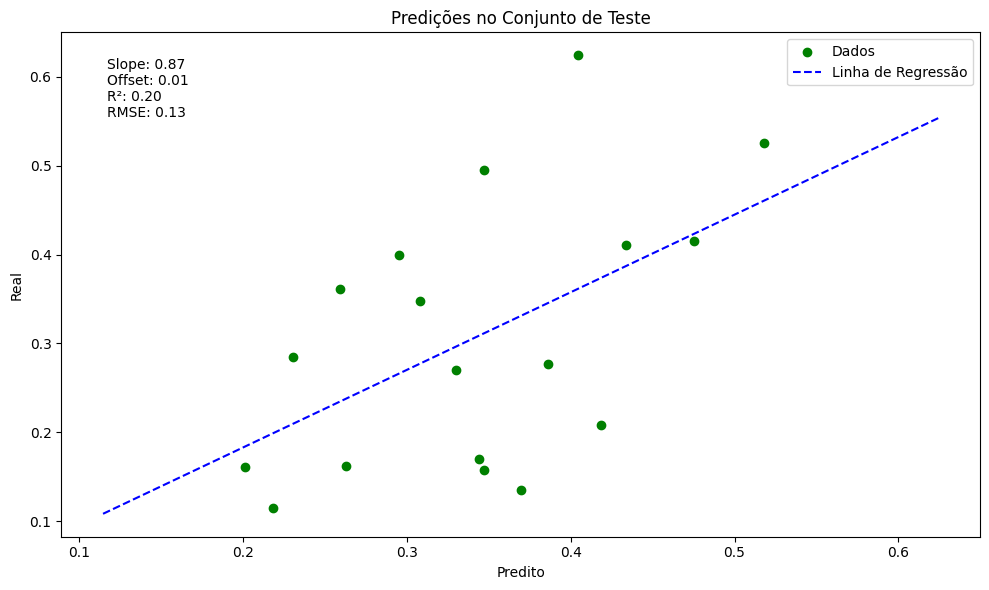

In [20]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 8:], df_sg_cal['ATT'].values, df_sg_val.iloc[:, 8:], df_sg_val['ATT'].values, 'SG', 'ATT')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'ATT')

=== Training Metrics ===
R²: 0.8275
Correlation coefficient: 0.9098
RMSE: 0.0108
MAE: 0.0060
Relative absolute error: 28.4128
Root relative squared error: 41.5337
Slope: 1.0120
Offset: -0.0018
=== Cross-Validation Metrics ===
R²: -2.2693
Correlation coefficient: 0.0149
RMSE: 0.0472
MAE: 0.0344
Relative absolute error: 162.3261
Root relative squared error: 180.8126
Slope: 0.0098
Offset: 0.1287
=== Validation Metrics ===
R²: -0.5986
Correlation coefficient: 0.3197
RMSE: 0.0216
MAE: 0.0168
Relative absolute error: 120.0049
Root relative squared error: 126.4369
Slope: 0.2826
Offset: 0.0978


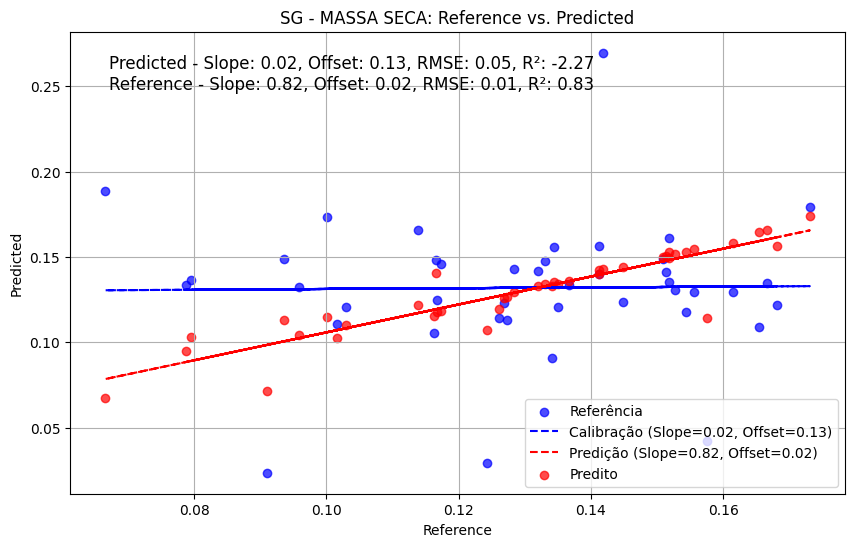

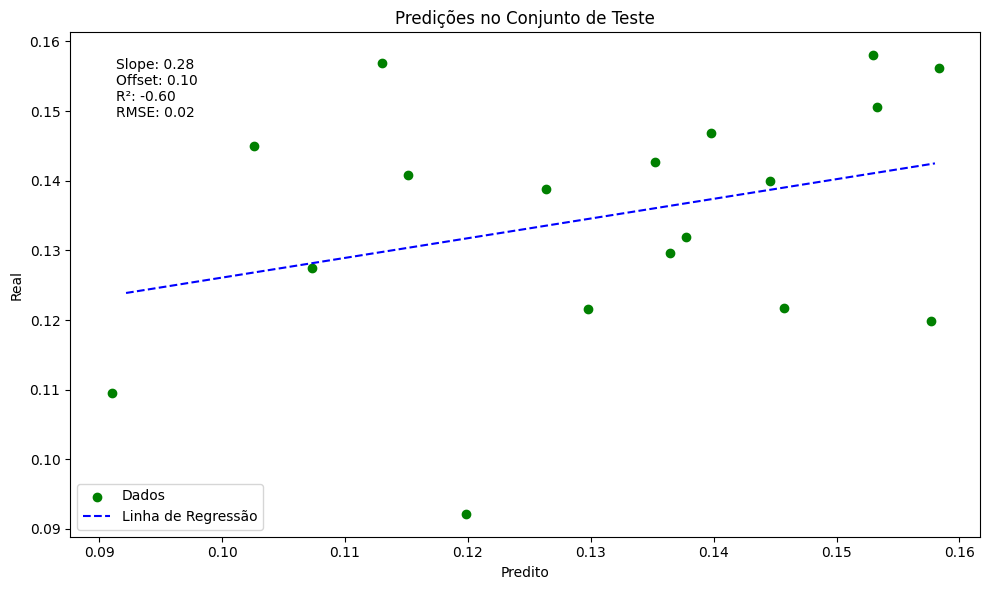

In [21]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 8:], df_sg_cal['MASSA SECA'].values, df_sg_val.iloc[:, 8:], df_sg_val['MASSA SECA'].values, 'SG', 'MASSA SECA')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'MASSA SECA')

In [22]:
infos_sg.to_excel('plot_infos_SVM_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.223404,0.575097,2.539836,1.855801,74.740490,88.124694,1.547853,-3.284595
1,SST,Cross-Validation,0.031054,0.319851,2.836990,2.259078,90.982062,98.435039,0.849302,1.856941
2,SST,Validation,-0.400806,0.692680,3.082673,2.698375,135.127270,118.355668,2.434398,-8.978176
3,FIRMEZA,Training,0.101328,0.613118,43.344585,39.323433,89.940518,94.798299,4.499496,-159.251839
4,FIRMEZA,Cross-Validation,0.022700,0.370708,45.201026,41.298845,94.458679,98.858494,3.234609,-97.446052
5,FIRMEZA,Validation,-0.104034,0.290244,41.637824,41.246484,116.329378,105.073039,2.430735,-81.804135
6,AAC,Training,0.190010,0.546786,5.968891,4.480319,87.493103,89.999463,2.509298,-44.341084
7,AAC,Cross-Validation,0.121305,0.398937,6.216884,4.801646,93.768075,93.738714,1.930261,-27.419150
8,AAC,Validation,0.166659,0.569819,4.094087,3.256189,92.929949,91.287488,2.382010,-40.115606
9,ATT,Training,0.630295,0.802370,0.090119,0.056064,46.778594,60.803339,1.160125,-0.056276
